# Рекомендация тарифов
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.  
Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».  
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.  
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

# Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Изучение файла

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

from joblib import dump, load

In [2]:
df = pd.read_csv('users_behavior.csv')
df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.columns = df.columns.str.lower()
df.info()
print('_ '*20)
print('Количество дубликатов:',df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Количество дубликатов: 0


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
def without_hue(ax, feature): # добавим функция для подсчета процентов
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

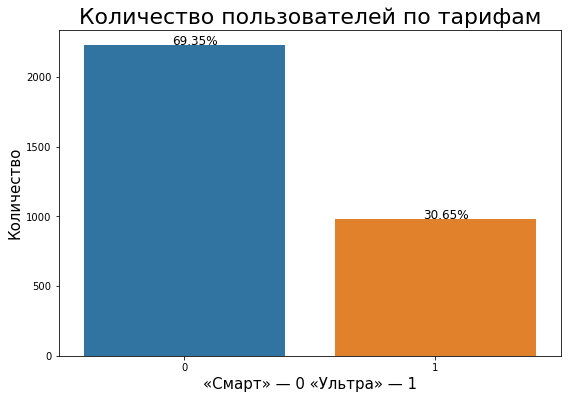

Тариф "Смарт"- 2229
Тариф "Ультра"- 985


In [6]:
plt.figure(figsize=(9, 6))
ax = sns.countplot(data = df,x='is_ultra')
plt.title('Количество пользователей по тарифам',fontsize=22)
plt.xlabel('«Смарт» — 0 «Ультра» — 1',fontsize=15)
plt.ylabel('Количество',fontsize=15)
without_hue(ax,df['is_ultra'])
plt.show()

print('Тариф "Смарт"-',(df['is_ultra'] == 0).sum())
print('Тариф "Ультра"-',(df['is_ultra'] == 1).sum())

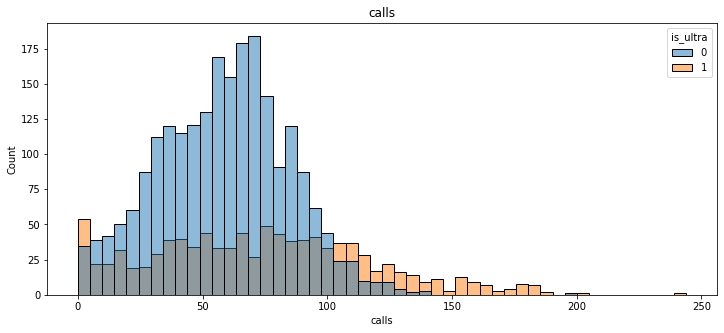

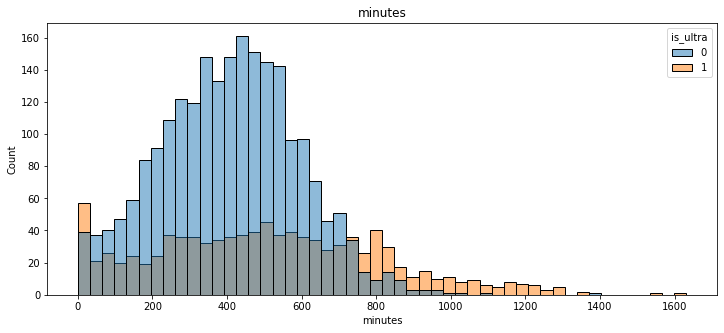

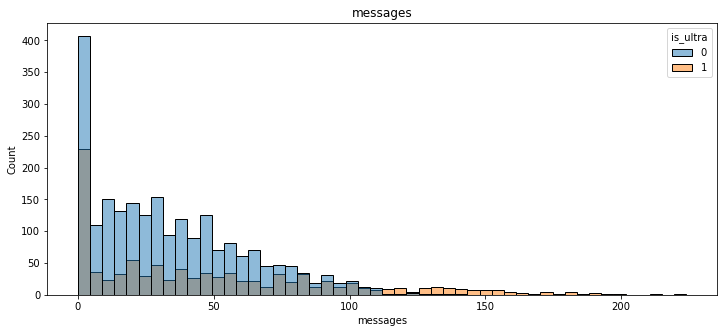

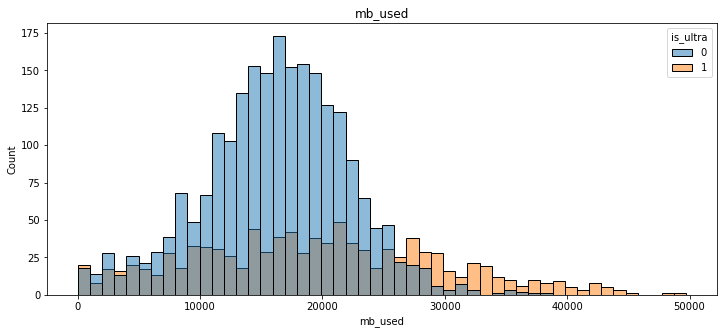

In [7]:
column = ['calls','minutes','messages','mb_used']

for i in df[column].columns:
    plt.figure(figsize=(12,5))
    plt.title(i)
    sns.histplot(data = df,x = df[i],hue="is_ultra",bins=50)   

Тариф "Смарт"- 2229   
Тариф "Ультра"- 985  
Количество пользователей тарифа Смарт больше в 2.2 раза.  
Пользователи тарифа "Ультра" расходуют больше минут,сообщений,МБ, так же чаще совершают звонки.

## Разбейте данные на выборки

In [8]:
features = df.drop(['is_ultra'],axis=1)
target = df['is_ultra']

In [9]:
features_train,features_test_valid,target_train,target_test_valid = train_test_split(features,target,
                                                                    test_size=0.4,random_state=12345,stratify=target)
features_test,features_valid,target_test,target_valid = train_test_split(features_test_valid,target_test_valid,
                                                        test_size = 0.5,random_state = 12345,stratify=target_test_valid)

In [10]:
print('Размер обучающей выборки',features_train.shape)
print('Размер валидационной выборки',features_valid.shape)
print('Размер тестовой выборки',features_test.shape)

Размер обучающей выборки (1928, 4)
Размер валидационной выборки (643, 4)
Размер тестовой выборки (643, 4)


In [11]:
features_tv = pd.concat([features_train,features_valid],axis = 0,ignore_index=True) #для GrinSearchCV 
target_tv = pd.concat([target_train,target_valid],axis = 0,ignore_index=True)
print('Размер обучающей+валидационной выборки',features_tv.shape)

(2571, 4)

## Исследуйте модели

### Дерево решений

Лучшая модель: DecisionTreeClassifier(max_depth=5, random_state=12345)
Accuracy лучшей  модели на валидационной выборке: 0.8118195956454122
Accuracy лучшей модели на обучающей выборке: 0.8874481327800829


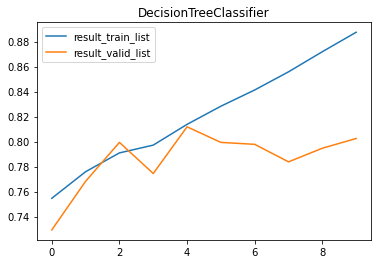

In [12]:
result_train_list = []
result_valid_list = []
best_result = 0
best_model = None
for depth in range(1,11): #функция для подбора оптимального кол-вадеревьев
    model = DecisionTreeClassifier(random_state = 12345,max_depth = depth)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    predictions_train = model.predict(features_train)
    result = accuracy_score(target_valid,predictions_valid)
    result_train = accuracy_score(target_train,predictions_train)
    result_train_list.append(result_train)#добавим значения на обучающей выборки в список
    result_valid_list.append(result)#добавим значения на валидациной выборки в список
    if result > best_result:
        best_model = model
        best_result = result
    
        
plt.plot(result_train_list)#представим на графике
plt.plot(result_valid_list)
plt.legend(['result_train_list','result_valid_list'])
plt.title('DecisionTreeClassifier')

print('Лучшая модель:',best_model)
print('Accuracy лучшей  модели на валидационной выборке:',best_result)
print('Accuracy лучшей модели на обучающей выборке:',result_train)
        

Лучшая модель: DecisionTreeClassifier(max_depth=5, random_state=12345)
Accuracy лучшей  модели на валидационной выборке: 0.8118195956454122
Accuracy лучшей модели на обучающей выборке: 0.8137966804979253
При параметре max_depth=5,модель хорошо обучена.

### Логистическая регрессия

In [13]:
model = LogisticRegression(penalty='l1',random_state = 12345,solver='liblinear',max_iter = 1000)
model.fit(features_train,target_train)
predict = model.predict(features_valid)
model.score(features_valid,target_valid)
print('Доля правильных ответов на валидационной выборке:',model.score(features_valid,target_valid))
print('Доля правильных ответов на обучающей выборке:',model.score(features_train,target_train))

Доля правильных ответов на валидационной выборке: 0.7465007776049767
Доля правильных ответов на обучающей выборке: 0.75


Логистическая регрессия показывает не лучший результат,скорее всего данный датасет имеет связь сложнее линейной 

### Случайный лес

In [14]:
best_result = 0
best_model = None
for est in range(1,7):
    for depth in range (1,7):
        model = RandomForestClassifier(random_state = 12345,n_estimators=est,max_depth = depth)
        model.fit(features_train,target_train)
        result = model.score(features_valid,target_valid)
        result_train = model.score(features_train,target_train)
        result_valid_list.append(result)
        result_train_list.append(result_train)
        print('Результат на каждом шаге',est,depth,result)
        if result > best_result:
            best_model = model
            best_result = result

print('Accuracy лучшей  модели на валидационной выборке:',best_result)
print('Лучшая модель:',best_model)

Результат на каждом шаге 1 1 0.7620528771384136
Результат на каждом шаге 1 2 0.7900466562986003
Результат на каждом шаге 1 3 0.7900466562986003
Результат на каждом шаге 1 4 0.7682737169517885
Результат на каждом шаге 1 5 0.7807153965785381
Результат на каждом шаге 1 6 0.7978227060653188
Результат на каждом шаге 2 1 0.7231726283048211
Результат на каждом шаге 2 2 0.7698289269051322
Результат на каждом шаге 2 3 0.8087091757387247
Результат на каждом шаге 2 4 0.7900466562986003
Результат на каждом шаге 2 5 0.7791601866251944
Результат на каждом шаге 2 6 0.7962674961119751
Результат на каждом шаге 3 1 0.7247278382581649
Результат на каждом шаге 3 2 0.7698289269051322
Результат на каждом шаге 3 3 0.8087091757387247
Результат на каждом шаге 3 4 0.7916018662519441
Результат на каждом шаге 3 5 0.7978227060653188
Результат на каждом шаге 3 6 0.8149300155520995
Результат на каждом шаге 4 1 0.7247278382581649
Результат на каждом шаге 4 2 0.7900466562986003
Результат на каждом шаге 4 3 0.807153965

In [28]:
%%time
clf = RandomForestClassifier(random_state=12345) 

parametrs = { 'n_estimators': range (1,20),
              'max_depth': range (1,20),
              'min_samples_leaf': [2,4,6,8],
              'min_samples_split': [2,4,6,8],
              'max_features':range (1,5)}
grid = GridSearchCV(clf, parametrs,error_score='raise', cv=5,n_jobs=-1)
grid.fit(features_tv, target_tv)
print(grid.best_score_)
print(grid.best_params_)


0.8090234596350723
{'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 12}
CPU times: total: 44.6 s
Wall time: 4min 37s


In [29]:
model = RandomForestClassifier(max_depth=8, n_estimators=12,max_features= 4,min_samples_leaf= 8, min_samples_split= 2)
model.fit(features_train,target_train)
result = model.score(features_valid,target_valid)
result_train = model.score(features_train,target_train)
dump(best_model, 'filename.joblib') #сохраним лучшую модель
print(result)
print(result_train)

0.8118195956454122
0.8386929460580913


## Проверьте модель на тестовой выборке

In [30]:
best_model = load('filename.joblib') 
result = best_model.score(features_test,target_test)
print(result)

0.7947122861586314


На тестовой выборке модель "Случайный Лес" показывает результат - 0.7947122861586314, на валидационной выборке - 0.8180404354587869.

In [31]:
model = RandomForestClassifier(random_state = 12345,n_estimators=10,max_depth = 7,min_samples_leaf=2,min_samples_split=8)
model.fit(features_tv,target_tv)
result = model.score(features_test,target_test)
result_train = model.score(features_tv,target_tv)
print('Результат на тестовой выборке,модель обучена на тренировочной + валидационной выборке',result)
print('Результат на  новой тренировочной выборке,которая состоит из тренировочной + валидационной выборке',result_train)

Результат на тестовой выборке,модель обучена на тренировочной + валидационной выборке 0.8289269051321928
Результат на  новой тренировочной выборке,которая состоит из тренировочной + валидационной выборке 0.838584208479191


## (бонус) Проверьте модели на адекватность

In [32]:
strategies = ['most_frequent', 'stratified', 'uniform', 'constant']
# Создадим константные предсказания с разными предсказаниями
test_scores = []
for s in strategies:
    if s =='constant':
        dclf = DummyClassifier(strategy = s, random_state = 12345, constant =1)
    else:
        dclf = DummyClassifier(strategy = s, random_state = 12345)
    dclf.fit(features_train, target_train)
    score = dclf.score(features_valid, target_valid)
    test_scores.append(score)
print(test_scores)

[0.6936236391912908, 0.5567651632970451, 0.49455676516329705, 0.30637636080870917]


При использовании классификатора со стратегией "самое частое",получаем результат доля правильных ответов 69,36%. Самый частый ответ будет "0".  
При использовании константы = 1,получаем долю правильных ответов 30,64%.  
При стратегии выставления ответов равномерно наугад ,доля правильных ответов 49,5%.  
При стратифицированный стратегии ,доля правильных ответов 55,7%.  
Исходя из этого, можно сделать вывод, что выбранная нами модель дает результат лучше, чем случайный классификатор или ,если по умолчанию поставить самое частое значение.

## Общий вывод


При проведение данной работы использовались модели обучения "Дерево решений","Случайный лес" и "Логистическая регрессия".
Лучший результат показала модель "Случайный лес",с результатом 0.8180404354587869,на валидационой выборке,0.7947122861586314 на тестовой выборке.
После этого модель дообучили на выборке тренировочная + валидационной,результат на тестовой выборке улучшился до 0.8289269051321928.